In [1]:
import time
import csv
import gc
import cv2
import os
import torch
import torchvision
#import torchmetrics
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import random


try:
    import segmentation_models_pytorch as smp
except:
    !pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
    !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
finally:
    import segmentation_models_pytorch as smp

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-dk0wicgc
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-dk0wicgc
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e5d3db20e9c2ddb76f88642409e527239943c983
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=106725 sha256=90100fc0e33a5790f5579b17d003ddbb30ad02ef46149ac2668afb77f9ce5edb
  Stored in directory: /tmp/pip-ephem-wheel-cache-h2pyy51v/wheels/1a/49/5f/858bc2741660e381e83f1d8b297edc4d9f0561f29becaee577
  Created wheel for efficientnet-pyt

In [2]:
#Learning model:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 1000
batch_size = 12
threshold = 0.5

#Optimizator


#Augmentation
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
HW = 256

In [3]:
my_transform = transforms.Compose([      
            transforms.Resize((HW, HW)),
            transforms.ToTensor(),
])

In [4]:
DATA_DIR = '../input/massachusetts-roads-dataset/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [5]:
class DroneDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, masks_dir):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir

        imgs_paths = os.listdir(self.imgs_dir)
        imgs_paths.sort()

        mask_paths = os.listdir(self.masks_dir)
        mask_paths.sort()

        self.imgs_paths = imgs_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.imgs_dir, self.imgs_paths[idx]))
        mask = Image.open(os.path.join(self.masks_dir, self.mask_paths[idx]))
        if random.random() > 0.5:
            angle = random.choice([0, 90, 180, 270])
            img = TF.rotate(img, angle)
            mask = TF.rotate(mask, angle)
        if random.random() > 0.5:
            img = TF.vflip(img)
            mask = TF.vflip(mask)
        if random.random() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
        trans_img = my_transform(img)  
        trans_label = my_transform(mask)
        new_mask = np.zeros((1, trans_label.shape[1], trans_label.shape[2]))
        new_mask[0] = np.where(trans_label == 0, 0, 1)
        trans_label = new_mask
        return trans_img, trans_label

In [6]:
train_dataset = DroneDataset(x_train_dir, y_train_dir)
valid_dataset = DroneDataset(x_valid_dir, y_valid_dir)
test_dataset = DroneDataset(x_test_dir, y_test_dir)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True,
                                           num_workers=0, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle = True,
                                           num_workers=0, drop_last=True)

test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = True,
                                           num_workers=0, drop_last=True)

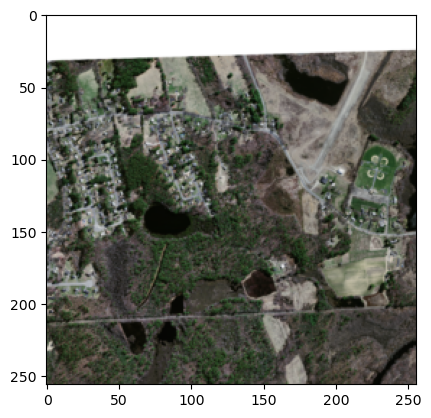

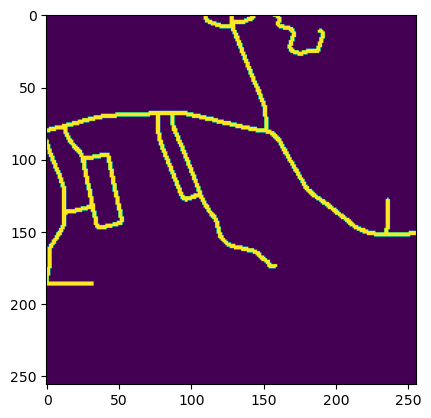

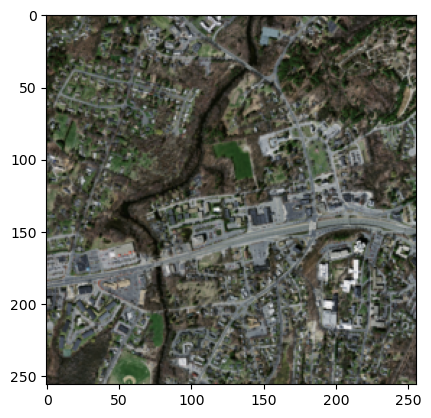

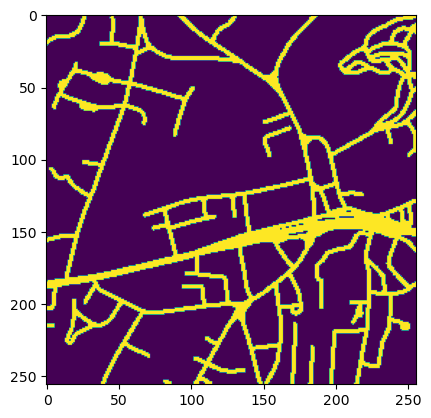

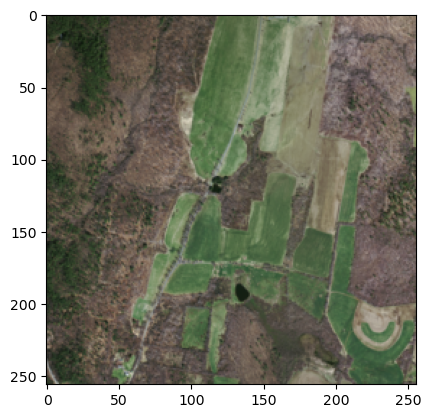

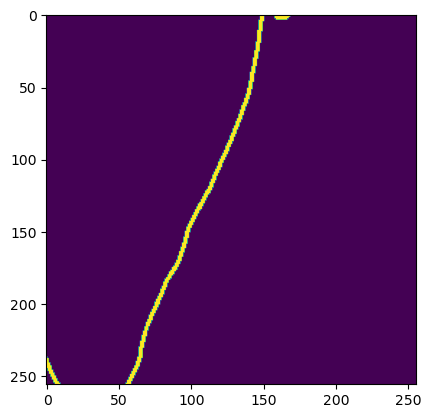

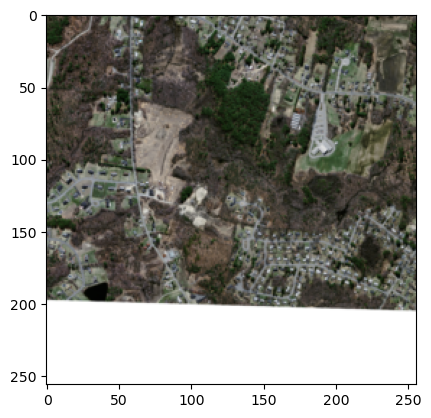

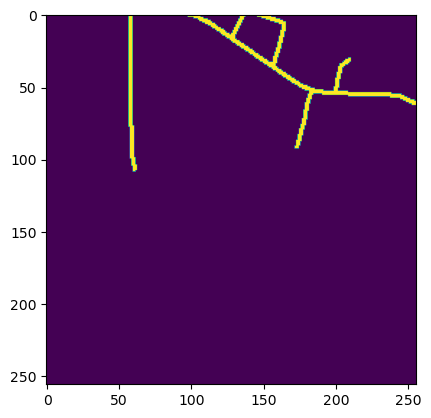

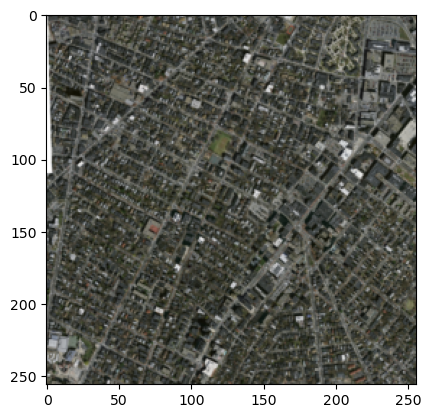

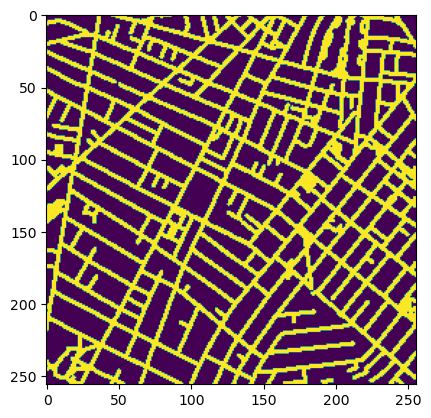

In [7]:
for i, (batch_img, batch_label) in enumerate(train_loader):
    img = batch_img[0]
    label = batch_label[0]
    np_img = img.numpy().transpose(1, 2, 0)
    np_label = label.numpy().transpose(1, 2, 0)
    plt.imshow(np_img)
    plt.show()
    plt.imshow(np_label)
    plt.show()
    if i % 5 == 4:
        break

In [8]:
length = len(train_loader) + len(train_loader) + len(train_loader)
print("Size of train dataset is", len(train_loader)* batch_size /length)
print("Size of valid dataset is", len(valid_loader)* batch_size /length)
print("Size of test dataset is",  len(test_loader) * batch_size /length)

Size of train dataset is 4.0
Size of valid dataset is 0.043478260869565216
Size of test dataset is 0.17391304347826086


In [9]:
class CNA(nn.Module):
    def __init__(self, in_channels, num_filters, kernel_size=3, stride=1, padding=1, bias=False):
        super(CNA, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, num_filters, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn   = nn.BatchNorm2d(num_filters)
        self.act  = nn.LeakyReLU(inplace = True)
                
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.act(out)
        return out

In [10]:
class DroneNet(nn.Module):
    def __init__(self):
        super(DroneNet, self).__init__()
        
        self.down1 = nn.Sequential( CNA(  3,  64), CNA( 64,  64) )      
        self.down2 = nn.Sequential( CNA( 64, 128), CNA(128, 128) )
        self.down3 = nn.Sequential( CNA(128, 256), CNA(256, 256) )
        self.down4 = nn.Sequential( CNA(256, 512), CNA(512, 512) )
        self.mp   = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.cna = CNA(512, 512)
        self.cna512 = CNA(512, 512)
        self.cna256 = CNA(256, 256)
        self.cna128 = CNA(128, 128)
        self.cna64  = CNA( 64,  64)
        self.cna32  = CNA( 32,  32)
        
        self.drop = nn.Dropout(0.2)
        
        self.up4 = nn.Sequential( CNA(512+512, 512), CNA(512, 512) )
        self.up3 = nn.Sequential( CNA(512+256, 256), CNA(256, 256) )
        self.up2 = nn.Sequential( CNA(256+128, 128), CNA(128, 128) )
        self.up1 = nn.Sequential( CNA(128+64 ,  32), CNA( 32,  32) )
        
        self.final = nn.Sequential( CNA(512+256+128+32,  1))
        
    def forward(self, x):
        x_deep1 = self.down1(x)
        (_,_,h1,w1) = (x_deep1.shape) 
        x = self.mp(x_deep1)
        
        x_deep2 = self.down2(x)
        (_,_,h2,w2) = (x_deep2.shape) 
        x = self.mp(x_deep2)
        
        x_deep3 = self.down3(x)
        (_,_,h3,w3) = (x_deep3.shape) 
        x = self.mp(x_deep3)
        
        x_deep4 = self.down4(x)
        (_,_,h4,w4) = (x_deep4.shape) 
        x = self.mp(x_deep4)
        
        x = self.cna(x)
        x = self.cna(x)
        
        x = F.upsample(x, size=(h4,w4), mode='bilinear', align_corners=True)
        x_deep4 = self.cna512(x_deep4)
        x = torch.cat((x_deep4, x), axis=1)
        del x_deep4
        x = self.up4(x)
        pred_x4 = x
        
        x = F.upsample(x, size=(h3,w3), mode='bilinear', align_corners=True)
        x_deep3 = self.cna256(x_deep3)
        x = torch.cat((x_deep3, x), axis=1)
        del x_deep3
        x = self.up3(x)
        pred_x3 = x
        
        x = F.upsample(x, size=(h2,w2), mode='bilinear', align_corners=True)
        x_deep2 = self.cna128(x_deep2)
        x = torch.cat((x_deep2, x), axis=1)
        del x_deep2
        x = self.up2(x)
        pred_x2 = x     
        
        x = F.upsample(x, size=(h1,w1), mode='bilinear', align_corners=True)
        x_deep1 = self.cna64(x_deep1)
        x = torch.cat((x_deep1, x), axis=1)
        del x_deep1
        x = self.up1(x)
        pred_x1 = x
        
        pred_x4 = self.cna512(pred_x4)
        pred_x3 = self.cna256(pred_x3)
        pred_x2 = self.cna128(pred_x2)
        pred_x1 = self.cna32(pred_x1)
        
        pred_x1 = F.upsample(pred_x1, size=(h1,w1), mode='bilinear', align_corners=True)
        pred_x2 = F.upsample(pred_x2, size=(h1,w1), mode='bilinear', align_corners=True)
        pred_x3 = F.upsample(pred_x3, size=(h1,w1), mode='bilinear', align_corners=True)
        pred_x4 = F.upsample(pred_x4, size=(h1,w1), mode='bilinear', align_corners=True)
        
        x = torch.cat((pred_x1, pred_x2, pred_x3, pred_x4), axis=1)
        x = self.drop(x)
        x = self.final(x)
        return x

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

In [12]:
model = DroneNet()
print(count_parameters(model))

20295842


In [13]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4)
criterion = smp.losses.DiceLoss(mode= 'binary')
criterion.__name__ = 'Loss'

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5)

print(device)
torch.cuda.empty_cache()
gc.collect()

cuda


16530

In [14]:
model_load = False
if model_load:
    model.load_state_dict(torch.load('/kaggle/input/my-models/up_model1.pt', map_location=device))

In [ ]:
def run(model, device, loaders, train_arg, epoch_num):
    print(f'-------------------------------------Learning begin, total of {num_epochs} epochs---------------------------------')
    
    #Подготовка к работе
    (optimizer, criterion, scheduler) = train_arg
    model = model.to(device)
    criterion = criterion.to(device)
    optimizer_to(optimizer, device)
    threshold = 0.9
    scaler = torch.cuda.amp.GradScaler()
    best_score = 0.73
    
    #Обучение/тестинг
    for epoch in range(epoch_num):
        print(f'----------------------------------------------------Epoch: {epoch}---------------------------------------------')
        for (loader, mode) in loaders:
            AVG_Loss = 0
            AVG_IoU = 0
            AVG_Accuracy = 0
                
            torch.cuda.empty_cache()
            gc.collect()
            
            if mode == "train":
                model = model.train()
            else:
                model = model.eval()
                
            with torch.set_grad_enabled(mode == 'train'):
                pbar = tqdm(enumerate(loader), total=len(loader), desc=mode)
                for i, (img, label) in pbar:
                    optimizer.zero_grad()
                    
                    with torch.cuda.amp.autocast(enabled=True):
                        net = torch.nn.DataParallel(model, device_ids=[0, 1])
                        out = net(img.to(device))
                        loss = criterion(out, label.to(device))
                    
                    if mode == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                
                    out = (out.sigmoid()).cpu()
                    pred = np.zeros(out.shape)
                    pred[:] = np.where(out >= threshold, 1, 0)
                    pred = torch.from_numpy(pred).int()

                    tp, fp, fn, tn = smp.metrics.get_stats(pred.long(), label.long(), mode='binary')
                    error = loss.item()
                    score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item()
                    acc = ((tp+tn+1e-12)/(tp+fp+fn+tn+1e-12)).mean().item()
                    AVG_Loss += error
                    AVG_IoU += score
                    AVG_Accuracy += acc
                    pbar.set_postfix({"Loss": error, "Accuracy": acc, "IoU": score, 
                                      "AVG_Loss": AVG_Loss/(i+1), "AVG_Accuracy": AVG_Accuracy/(i+1), 
                                      "AVG_IoU": AVG_IoU/(i+1)                                                           
                                     })
                    
                if mode == "train":
                    scheduler.step()
                    
                AVG_IoU = AVG_IoU / len(loader)
                if mode == 'test' and AVG_IoU > best_score + 0.01/best_score:
                    best_score = AVG_IoU
                    torch.save(model, '/kaggle/working/best_model.pt')
                    print('Model saved! Best score:', best_score)
                            
loaders = [(train_loader, "train"), (valid_loader, "valid"),(test_loader, "test")]
run(model, device, loaders, (optimizer, criterion, scheduler), num_epochs)

-------------------------------------Learning begin, total of 1000 epochs---------------------------------
----------------------------------------------------Epoch: 0---------------------------------------------


test: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it, Loss=0.71, Accuracy=0.907, IoU=0.276, AVG_Loss=0.712, AVG_Accuracy=0.912, AVG_IoU=0.314] 


----------------------------------------------------Epoch: 1---------------------------------------------


test: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it, Loss=0.7, Accuracy=0.925, IoU=0.494, AVG_Loss=0.695, AVG_Accuracy=0.925, AVG_IoU=0.495]  


----------------------------------------------------Epoch: 2---------------------------------------------


test: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, Loss=0.69, Accuracy=0.934, IoU=0.477, AVG_Loss=0.699, AVG_Accuracy=0.929, AVG_IoU=0.46]  


----------------------------------------------------Epoch: 3---------------------------------------------


test: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it, Loss=0.67, Accuracy=0.91, IoU=0.441, AVG_Loss=0.688, AVG_Accuracy=0.934, AVG_IoU=0.532]  


----------------------------------------------------Epoch: 4---------------------------------------------


test: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, Loss=0.681, Accuracy=0.938, IoU=0.545, AVG_Loss=0.701, AVG_Accuracy=0.938, AVG_IoU=0.501]


----------------------------------------------------Epoch: 5---------------------------------------------


train:  52%|█████▏    | 48/92 [01:12<01:06,  1.51s/it, Loss=0.711, Accuracy=0.938, IoU=0.453, AVG_Loss=0.708, AVG_Accuracy=0.924, AVG_IoU=0.438]

In [ ]:
weights = []
for name, param in model.named_parameters():
    if 'weight' in name:
        weights += param.data.cpu().numpy().flatten().tolist()

weights = np.array(weights)

# Построение гистограммы
plt.hist(weights, bins=800, range = (-0.004, 0.004))
plt.xlabel('Weight values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
zero_weights = (np.where(abs(weights)==0.0, 1, 0)).sum()
print("Zero weights:", 100*zero_weights/len(weights), "%")

In [ ]:
del train_loader
del valid_loader

In [ ]:
threshold = 0.9
torch.cuda.empty_cache()
gc.collect()
model = model.to(device)
with torch.no_grad():
    model.eval()
    for batch_img, batch_label in test_loader:
        batch_img = batch_img.to(device)
        batch_pred_mask = model(batch_img)
        img = batch_img[0].cpu()
        label = batch_label[0].cpu()
        pred_mask = batch_pred_mask[0].cpu().sigmoid()
        np_img = img.numpy().transpose(1, 2, 0)
        np_label = label.numpy().transpose(1, 2, 0)
        np_mask = pred_mask.numpy().transpose(1, 2, 0)
        one_hot_mask = np.where(np_mask > threshold, 1, 0)
        plt.imshow(np_img)
        plt.show()
        plt.imshow(np_label)
        plt.show()
        #plt.imshow(np_mask)
        #plt.show()
        plt.imshow(one_hot_mask)
        plt.show()
        break

In [ ]:
model_save = True
if model_save:
    torch.save(model.state_dict(), 'up_model1.pt')

In [ ]:
1 2   -> stride 2
4 5  

In [ ]:
0 1 kernel
2 3

In [ ]:
0  0  0  2
0  0  4  6
0  4  0  5
8 10 10 15

In [ ]:
1 2   -> stride 1
4 5  

In [ ]:
0 1
2 3

In [ ]:
0 1 0    0 0 2
2 3 0  + 0 4 6 + ... = 
0 0 0    0 0 0

In [ ]:
alpha = momentum * runn_alpha + (1-momentum)*save

In [ ]:
gamma = momentum